<a href="https://colab.research.google.com/github/aauliariza/stroke-prediction/blob/main/project_without_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
print("Installing dependencies... This may take a few minutes.")
print("="*70)

!pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn --quiet
print("Core ML libraries installed (pandas, numpy, scikit-learn, xgboost, imbalanced-learn, matplotlib, seaborn)")

!pip install pytorch-tabnet --quiet
print("PyTorch TabNet installed")

# Install CPU-only PyTorch (Windows) to avoid DLL/CUDA mismatches
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --quiet
print("PyTorch CPU-only wheel installed")

Installing dependencies... This may take a few minutes.
Core ML libraries installed (pandas, numpy, scikit-learn, xgboost, imbalanced-learn, matplotlib, seaborn)
PyTorch TabNet installed
PyTorch CPU-only wheel installed


## 1. Import Libraries

In [38]:
import os
import glob
import zipfile
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer # Added KNNImputer import

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Preventing Data Leakage
from imblearn.pipeline import Pipeline as ImbPipeline

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc, precision_recall_curve)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")

def find_optimal_threshold_f2(y_true, y_proba):
    """
    Finds the optimal probability threshold that maximizes the F2-score.

    Args:
        y_true (array-like): True binary labels.
        y_proba (array-like): Predicted probabilities for the positive class.

    Returns:
        float: The optimal threshold.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f2_scores = []
    for i in range(len(precision)):
        if (precision[i] + 4 * recall[i]) == 0:
            f2_scores.append(0)
        else:
            f2_scores.append((5 * precision[i] * recall[i]) / (4 * precision[i] + recall[i]))
    # Filter out NaN/inf and find the index of the max F2-score
    f2_scores = np.array(f2_scores)
    max_f2_idx = np.argmax(f2_scores)
    optimal_threshold = thresholds[max_f2_idx]
    return optimal_threshold

All libraries imported successfully!
Random State: 42


## 2. Load Dataset

In [39]:
# 1. Define SVM Pipeline
# This pipeline will handle imputation and scaling for SVM, crucial for 'bmi' NaNs.
# probability=True is needed for predict_proba in ensemble steps.
svm_pipeline = ImbPipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=RANDOM_STATE, probability=True))
])

print("SVM pipeline (with KNNImputer, StandardScaler, and SVC) defined.")
print("Note: Data loading, encoding, and splitting are handled in other dedicated cells.")

SVM pipeline (with KNNImputer, StandardScaler, and SVC) defined.
Note: Data loading, encoding, and splitting are handled in other dedicated cells.


In [40]:
def load_data_from_path(filepath):
    print("\n" + "="*80)
    print("LOADING DATASET")
    print("="*80)

    # Ensure file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # Check extension is CSV
    file_ext = os.path.splitext(filepath)[1].lower()
    if file_ext != '.csv':
        raise ValueError(f"Unsupported file format: {file_ext}. Please provide a .csv file.")

    # Read CSV
    df = pd.read_csv(filepath)
    print(f"\n✓ Dataset loaded: {os.path.basename(filepath)}")
    print(f"  Full path: {os.path.abspath(filepath)}")
    return df

In [41]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

try:
    df = pd.read_csv(df)
except:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Display basic information
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\n" + "="*70)
print("FIRST 5 ROWS:")
print("="*70)
display(df.head())

print("\n" + "="*70)
print("DATASET INFORMATION:")
print("="*70)
print(df.info())

print("\n" + "="*70)
print("STATISTICAL SUMMARY:")
print("="*70)
display(df.describe())


Dataset Shape: (5110, 12)
Rows: 5110, Columns: 12

FIRST 5 ROWS:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

STATISTICAL SUMMARY:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 3. Exploratory Data Analysis (EDA)

TARGET VARIABLE DISTRIBUTION (Stroke)
No Stroke (0): 4861 (95.13%)
Stroke (1): 249 (4.87%)

Class Imbalance Ratio: 1:19.52


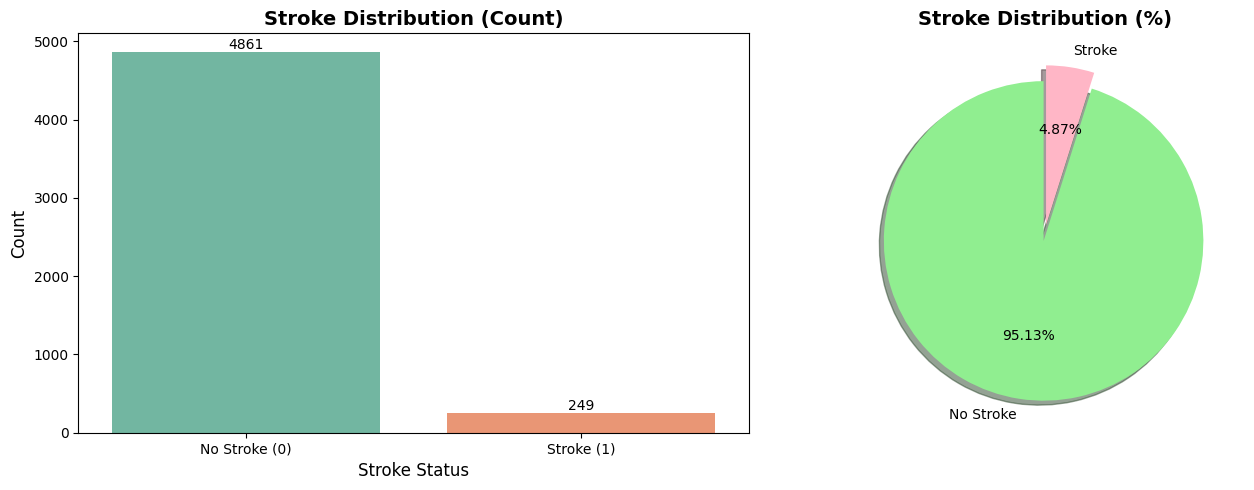


MISSING VALUES:


,Missing Count,Percentage
bmi,201,3.933464


In [42]:
# Class distribution
print("="*70)
print("TARGET VARIABLE DISTRIBUTION (Stroke)")
print("="*70)
stroke_counts = df['stroke'].value_counts()
stroke_percentages = df['stroke'].value_counts(normalize=True) * 100

print(f"No Stroke (0): {stroke_counts[0]} ({stroke_percentages[0]:.2f}%)")
print(f"Stroke (1): {stroke_counts[1]} ({stroke_percentages[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: 1:{stroke_counts[0]/stroke_counts[1]:.2f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='stroke', ax=axes[0], palette='Set2')
axes[0].set_title('Stroke Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Stroke (0)', 'Stroke (1)'])

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Pie chart
colors = ['#90EE90', '#FFB6C6']
explode = (0.05, 0.05)
axes[1].pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.2f%%',
           colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Stroke Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Missing values
print("\n" + "="*70)
print("MISSING VALUES:")
print("="*70)
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("No missing values found!")

## 4. Feature Distribution Analysis

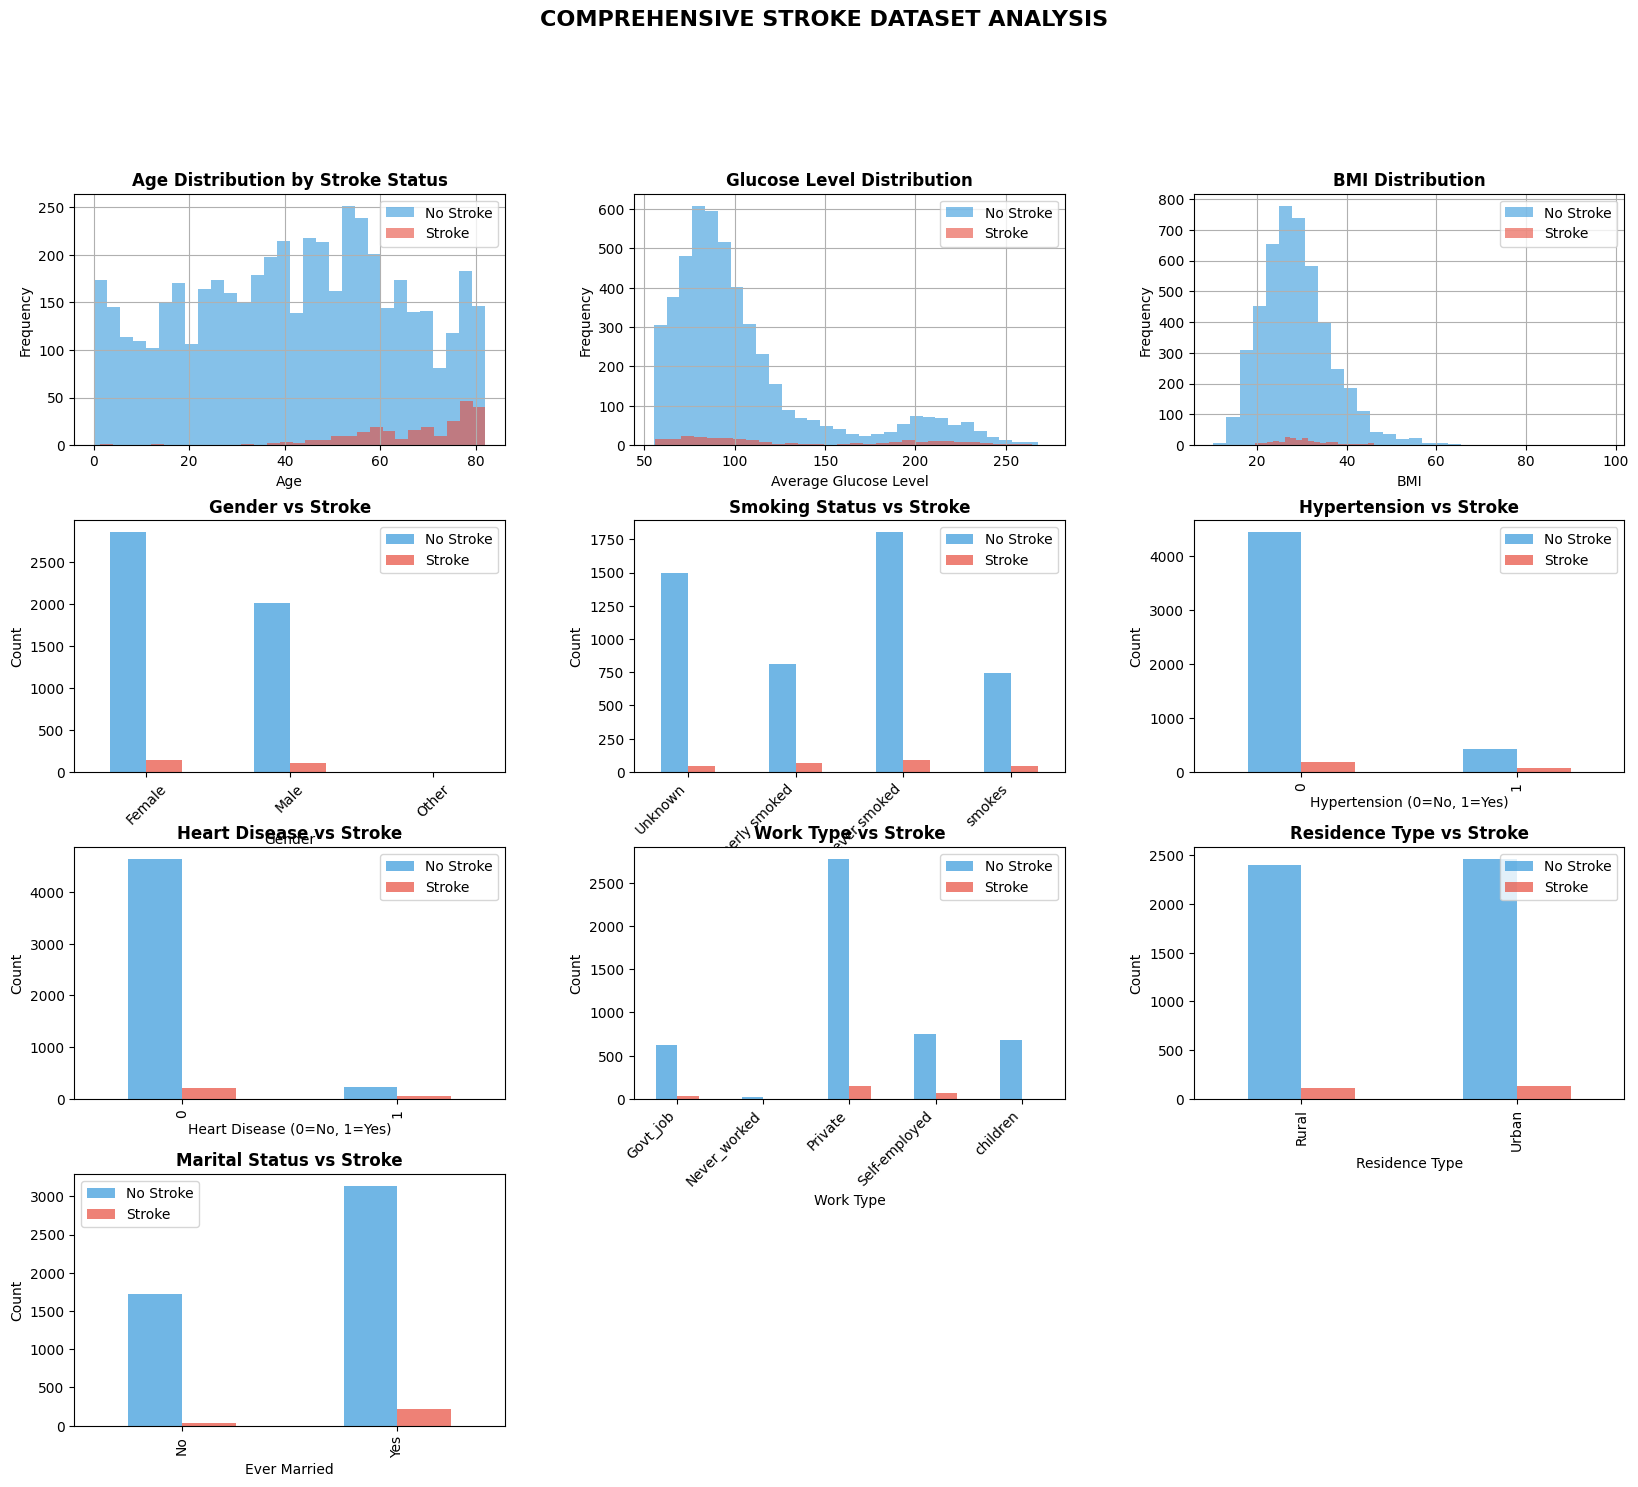

In [43]:
from matplotlib.gridspec import GridSpec

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Age Distribution by Stroke
ax2 = fig.add_subplot(gs[0, 0])
df[df['stroke']==0]['age'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax2)
df[df['stroke']==1]['age'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax2)
ax2.set_title('Age Distribution by Stroke Status', fontsize=12, fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.legend()

# 2. Average Glucose Level Distribution
ax3 = fig.add_subplot(gs[0, 1])
df[df['stroke']==0]['avg_glucose_level'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax3)
df[df['stroke']==1]['avg_glucose_level'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax3)
ax3.set_title('Glucose Level Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Average Glucose Level')
ax3.set_ylabel('Frequency')
ax3.legend()

# 3. BMI Distribution
ax4 = fig.add_subplot(gs[0, 2])
df[df['stroke']==0]['bmi'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax4)
df[df['stroke']==1]['bmi'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax4)
ax4.set_title('BMI Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('BMI')
ax4.set_ylabel('Frequency')
ax4.legend()

# 4. Gender Distribution
ax5 = fig.add_subplot(gs[1, 0])
gender_stroke = pd.crosstab(df['gender'], df['stroke'])
gender_stroke.plot(kind='bar', ax=ax5, color=['#3498db', '#e74c3c'], alpha=0.7)
ax5.set_title('Gender vs Stroke', fontsize=12, fontweight='bold')
ax5.set_xlabel('Gender')
ax5.set_ylabel('Count')
ax5.legend(['No Stroke', 'Stroke'])
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)

# 5. Smoking Status
ax6 = fig.add_subplot(gs[1, 1])
smoking_stroke = pd.crosstab(df['smoking_status'], df['stroke'])
smoking_stroke.plot(kind='bar', ax=ax6, color=['#3498db', '#e74c3c'], alpha=0.7)
ax6.set_title('Smoking Status vs Stroke', fontsize=12, fontweight='bold')
ax6.set_xlabel('Smoking Status')
ax6.set_ylabel('Count')
ax6.legend(['No Stroke', 'Stroke'])
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')

# 6. Hypertension
ax7 = fig.add_subplot(gs[1, 2])
hypertension_stroke = pd.crosstab(df['hypertension'], df['stroke'])
hypertension_stroke.plot(kind='bar', ax=ax7, color=['#3498db', '#e74c3c'], alpha=0.7)
ax7.set_title('Hypertension vs Stroke', fontsize=12, fontweight='bold')
ax7.set_xlabel('Hypertension (0=No, 1=Yes)')
ax7.set_ylabel('Count')
ax7.legend(['No Stroke', 'Stroke'])

# 7. Heart Disease
ax8 = fig.add_subplot(gs[2, 0])
heart_stroke = pd.crosstab(df['heart_disease'], df['stroke'])
heart_stroke.plot(kind='bar', ax=ax8, color=['#3498db', '#e74c3c'], alpha=0.7)
ax8.set_title('Heart Disease vs Stroke', fontsize=12, fontweight='bold')
ax8.set_xlabel('Heart Disease (0=No, 1=Yes)')
ax8.set_ylabel('Count')
ax8.legend(['No Stroke', 'Stroke'])

# 8. Work Type
ax9 = fig.add_subplot(gs[2, 1])
work_stroke = pd.crosstab(df['work_type'], df['stroke'])
work_stroke.plot(kind='bar', ax=ax9, color=['#3498db', '#e74c3c'], alpha=0.7)
ax9.set_title('Work Type vs Stroke', fontsize=12, fontweight='bold')
ax9.set_xlabel('Work Type')
ax9.set_ylabel('Count')
ax9.legend(['No Stroke', 'Stroke'])
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right')

# 9. Residence Type
ax10 = fig.add_subplot(gs[2, 2])
residence_stroke = pd.crosstab(df['Residence_type'], df['stroke'])
residence_stroke.plot(kind='bar', ax=ax10, color=['#3498db', '#e74c3c'], alpha=0.7)
ax10.set_title('Residence Type vs Stroke', fontsize=12, fontweight='bold')
ax10.set_xlabel('Residence Type')
ax10.set_ylabel('Count')
ax10.legend(['No Stroke', 'Stroke'])

# 10. Ever Married
ax11 = fig.add_subplot(gs[3, 0])
married_stroke = pd.crosstab(df['ever_married'], df['stroke'])
married_stroke.plot(kind='bar', ax=ax11, color=['#3498db', '#e74c3c'], alpha=0.7)
ax11.set_title('Marital Status vs Stroke', fontsize=12, fontweight='bold')
ax11.set_xlabel('Ever Married')
ax11.set_ylabel('Count')
ax11.legend(['No Stroke', 'Stroke'])

plt.suptitle('COMPREHENSIVE STROKE DATASET ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [44]:
print("\n" + "="*70)
print("MINIMAL PREPROCESSING: Separating X, y and One-Hot Encoding")
print("="*70)

# Create a temporary copy to avoid modifying the original df for potential future use cases.
df_temp = df.copy()

# 1. Drop 'id' column as it's a unique identifier and not useful for modeling
df_temp = df_temp.drop('id', axis=1)
print("Dropped 'id' column.")

# 2. Handle 'Other' gender: it has only 1 instance and can cause issues with training or encoding.
df_temp = df_temp[df_temp['gender'] != 'Other']
print("Removed row with 'gender' as 'Other'.")

# 3. Separate target variable (y) and features (X)
X = df_temp.drop('stroke', axis=1)
y = df_temp['stroke']

# 4. Identify categorical columns (after dropping 'id' and 'stroke')
categorical_cols = X.select_dtypes(include=['object']).columns

# 5. One-Hot Encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"Shape of X after one-hot encoding: {X_encoded.shape}")
print("Categorical features have been one-hot encoded.")
print("Note: 'bmi' column still contains NaN values. These will be handled by specific model pipelines (e.g., SVM's pipeline includes an imputer) or require explicit imputation before model training.")
print("Minimal preprocessing completed. `X_encoded` and `y` are now defined.")


MINIMAL PREPROCESSING: Separating X, y and One-Hot Encoding
Dropped 'id' column.
Removed row with 'gender' as 'Other'.
Shape of X after one-hot encoding: (5109, 15)
Categorical features have been one-hot encoded.
Note: 'bmi' column still contains NaN values. These will be handled by specific model pipelines (e.g., SVM's pipeline includes an imputer) or require explicit imputation before model training.
Minimal preprocessing completed. `X_encoded` and `y` are now defined.


In [45]:
print("\n" + "="*70)
print("STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS")
print("="*70)

# Split into training and temporary (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Split temporary set into validation and test sets (2/3 for val, 1/3 for test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1/3), random_state=RANDOM_STATE, stratify=y_temp)

print("\nDataset Split Ratio: Train (70%) : Validation (20%) : Test (10%)")
print(f"Total samples: {len(X_encoded)}")
print(f"-------------------------------------------------------")
print(f"X_train shape: {X_train.shape} (Number of samples: {len(X_train)})")
print(f"y_train shape: {y_train.shape} (Number of samples: {len(y_train)})")
print(f"X_val shape: {X_val.shape} (Number of samples: {len(X_val)})")
print(f"y_val shape: {y_val.shape} (Number of samples: {len(y_val)})")
print(f"X_test shape: {X_test.shape} (Number of samples: {len(X_test)})")
print(f"y_test shape: {y_test.shape} (Number of samples: {len(y_test)})")
print(f"-------------------------------------------------------")

print("Data splitting completed successfully!")


STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS

Dataset Split Ratio: Train (70%) : Validation (20%) : Test (10%)
Total samples: 5109
-------------------------------------------------------
X_train shape: (3576, 15) (Number of samples: 3576)
y_train shape: (3576,) (Number of samples: 3576)
X_val shape: (1022, 15) (Number of samples: 1022)
y_val shape: (1022,) (Number of samples: 1022)
X_test shape: (511, 15) (Number of samples: 511)
y_test shape: (511,) (Number of samples: 511)
-------------------------------------------------------
Data splitting completed successfully!


## 6. Machine Learning Model

### 1. Support Vector Machine (SVM)

MODEL 1: SUPPORT VECTOR MACHINE (SVM)

Starting Grid Search for SVM with Pipeline...
Note: Using X_train (original split with NaNs in BMI) instead of balanced/scaled data to prevent leakage.
Fitting 5 folds for each of 36 candidates, totalling 180 fits

BEST HYPERPARAMETERS:
Best Parameters: {'imputer__n_neighbors': 3, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best Recall Score (CV): 0.0346

Optimal Threshold (F2-score) for SVM on Validation Set: 0.0553

VALIDATION SET PERFORMANCE:
Accuracy: 0.6859
Precision: 0.0931
Recall: 0.6200
F1-Score: 0.1619
ROC-AUC: 0.6359
Optimal_Threshold: 0.0553

Confusion Matrix:
[[670 302]
 [ 19  31]]


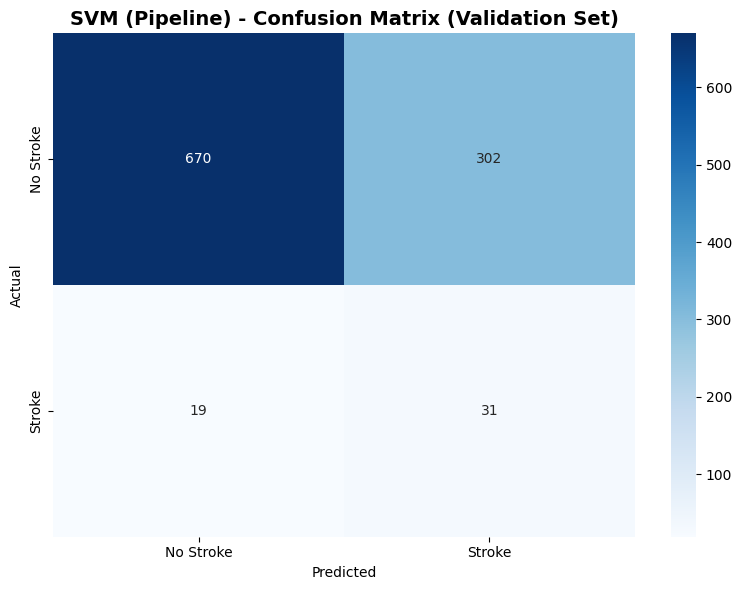


SVM model training and evaluation completed!


In [46]:
print("="*70)
print("MODEL 1: SUPPORT VECTOR MACHINE (SVM)")
print("="*70)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
# Note: We use 'svm__' prefix to access SVM parameters inside the pipeline
svm_param_grid = {
    'imputer__n_neighbors': [3, 5, 7], # Hyperparameter for KNNImputer
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear'],
    'svm__gamma': ['scale', 'auto']
}

print("\nStarting Grid Search for SVM with Pipeline...")
print("Note: Using X_train (original split with NaNs in BMI) instead of balanced/scaled data to prevent leakage.")

# Run GridSearchCV using X_train and y_train (Original data)
# The pipeline handles imputation, scaling and balancing internally
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=cv,
    scoring='recall', # We prioritize Recall for medical diagnosis
    n_jobs=-1,
    verbose=1
)

# Fit on the original training data
# X_train still has NaN values in 'bmi' at this stage, which the imputer in the pipeline will handle.
svm_grid_search.fit(X_train, y_train)

# Get best model and parameters
best_svm = svm_grid_search.best_estimator_

print("\n" + "="*70)
print("BEST HYPERPARAMETERS:")
print("="*70)
print(f"Best Parameters: {svm_grid_search.best_params_}")
print(f"Best Recall Score (CV): {svm_grid_search.best_score_:.4f}")

# Evaluate on Validation Set
# The pipeline automatically handles imputation and scaling of validation data using statistics from X_train
# It does NOT apply SMOTE to validation data (which is correct)
y_val_proba_svm = best_svm.predict_proba(X_val)[:, 1]

# Find optimal threshold for F2-score
optimal_threshold_svm = find_optimal_threshold_f2(y_val, y_val_proba_svm)
print(f"\nOptimal Threshold (F2-score) for SVM on Validation Set: {optimal_threshold_svm:.4f}")

# Generate predictions using the optimal threshold
y_val_pred_svm = (y_val_proba_svm >= optimal_threshold_svm).astype(int)

# Calculate metrics on validation set
svm_metrics = {
    'Model': 'SVM (Pipeline)',
    'Accuracy': accuracy_score(y_val, y_val_pred_svm),
    'Precision': precision_score(y_val, y_val_pred_svm),
    'Recall': recall_score(y_val, y_val_pred_svm),
    'F1-Score': f1_score(y_val, y_val_pred_svm),
    'ROC-AUC': roc_auc_score(y_val, y_val_proba_svm),
    'Optimal_Threshold': optimal_threshold_svm
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in svm_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
print("\nConfusion Matrix:")
print(cm_svm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('SVM (Pipeline) - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nSVM model training and evaluation completed!")

### 2. TabNet

MODEL 2: TABNET

TabNet Hyperparameters:
   n_d: 32
   n_a: 32
   n_steps: 3
   gamma: 1.3
   n_independent: 2
   n_shared: 2
   lambda_sparse: 0.001
   optimizer_fn: <class 'torch.optim.adam.Adam'>
   optimizer_params: {'lr': 0.02}
   mask_type: sparsemax
   scheduler_params: {'step_size': 10, 'gamma': 0.9}
   scheduler_fn: <class 'torch.optim.lr_scheduler.StepLR'>
   seed: 42
   verbose: 1

Applying minimal imputation and scaling for TabNet (necessary as TabNet cannot handle NaNs)...
Data prepared for TabNet (imputed and scaled).

Training TabNet model...
This may take several minutes...
epoch 0  | loss: 0.48506 | validation_auc: 0.6995  |  0:00:00s
epoch 1  | loss: 0.1916  | validation_auc: 0.62524 |  0:00:01s
epoch 2  | loss: 0.17962 | validation_auc: 0.72168 |  0:00:01s
epoch 3  | loss: 0.17898 | validation_auc: 0.77697 |  0:00:02s
epoch 4  | loss: 0.17603 | validation_auc: 0.74678 |  0:00:02s
epoch 5  | loss: 0.16382 | validation_auc: 0.77689 |  0:00:03s
epoch 6  | loss: 0.16234 

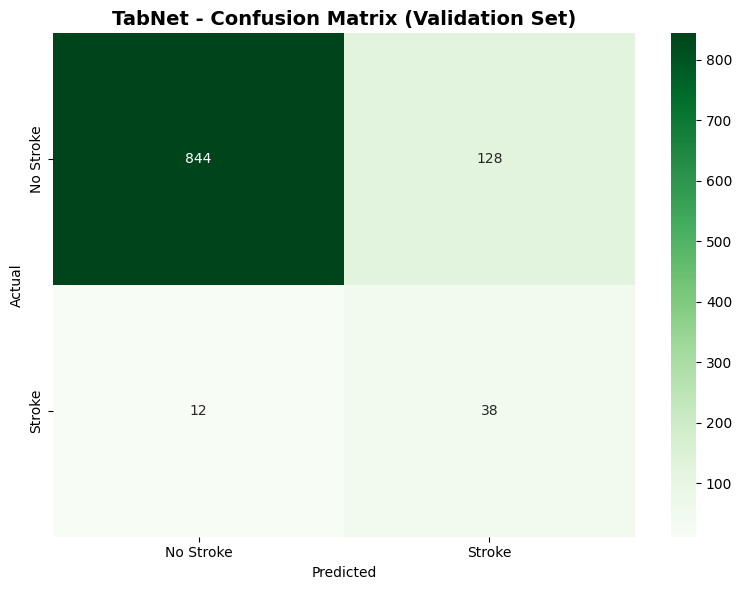


FEATURE IMPORTANCE (TabNet):
                           Feature  Importance
0                              age    0.302933
6                 ever_married_Yes    0.121499
5                      gender_Male    0.111586
11            Residence_type_Urban    0.095662
12  smoking_status_formerly smoked    0.088174
8                work_type_Private    0.084163
4                              bmi    0.057587
3                avg_glucose_level    0.029446
1                     hypertension    0.026106
14           smoking_status_smokes    0.025761


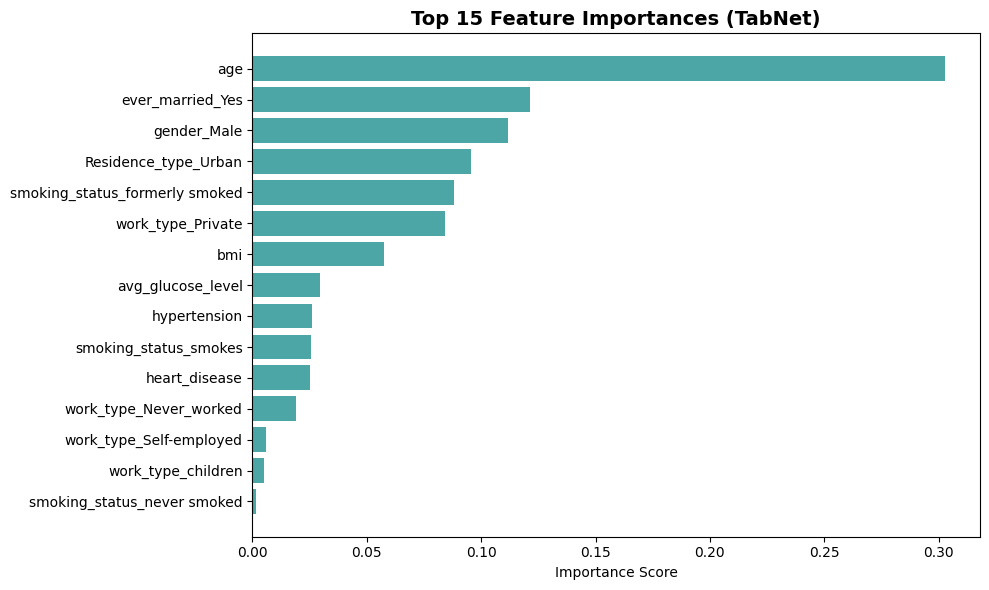


TabNet model training and evaluation completed!


In [47]:
print("="*70)
print("MODEL 2: TABNET")
print("="*70)

import torch.optim # Import torch.optim for the optimizer function

# Define TabNet hyperparameters based on paper recommendations
tabnet_params = {
    'n_d': 32,  # Decision layer dimension
    'n_a': 32,  # Attention layer dimension
    'n_steps': 3,
    'gamma': 1.3,
    'n_independent': 2,
    'n_shared': 2,
    'lambda_sparse': 1e-3,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2),
    'mask_type': 'sparsemax',
    'scheduler_params': {"step_size": 10, "gamma": 0.9},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'seed': RANDOM_STATE,
    'verbose': 1
}

print("\nTabNet Hyperparameters:")
for param, value in tabnet_params.items():
    print(f"   {param}: {value}")

# Initialize TabNet
tabnet_model = TabNetClassifier(**tabnet_params)

# --- Minimal Preprocessing for TabNet (Imputation and Scaling) ---
# TabNet cannot handle NaNs, so imputation is necessary.
# Scaling is also beneficial for neural networks like TabNet.
print("\nApplying minimal imputation and scaling for TabNet (necessary as TabNet cannot handle NaNs)...")
imputer_tabnet = KNNImputer(n_neighbors=5)
scaler_tabnet = StandardScaler()

# Impute and Scale training data
X_train_imputed_scaled_tabnet = scaler_tabnet.fit_transform(imputer_tabnet.fit_transform(X_train))
y_train_tabnet = y_train.values # TabNet expects numpy array for target

# Impute and Scale validation data using the _fitted_ imputer and scaler
X_val_imputed_scaled_tabnet = scaler_tabnet.transform(imputer_tabnet.transform(X_val))
y_val_tabnet = y_val.values

# Impute and Scale test data using the _fitted_ imputer and scaler
X_test_imputed_scaled_tabnet = scaler_tabnet.transform(imputer_tabnet.transform(X_test))

print("Data prepared for TabNet (imputed and scaled).")

print("\nTraining TabNet model...")
print("This may take several minutes...")

# Train TabNet with early stopping
tabnet_model.fit(
    X_train_imputed_scaled_tabnet, y_train_tabnet,
    eval_set=[(X_val_imputed_scaled_tabnet, y_val_tabnet)],
    eval_name=['validation'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

print("\nTabNet training completed!")

# Predictions on validation set
y_val_pred_proba_tabnet = tabnet_model.predict_proba(X_val_imputed_scaled_tabnet)[:, 1]

# Find optimal threshold for F2-score
optimal_threshold_tabnet = find_optimal_threshold_f2(y_val, y_val_pred_proba_tabnet)
print(f"\nOptimal Threshold (F2-score) for TabNet on Validation Set: {optimal_threshold_tabnet:.4f}")

# Generate predictions using the optimal threshold
y_val_pred_tabnet = (y_val_pred_proba_tabnet >= optimal_threshold_tabnet).astype(int)

# Calculate metrics
tabnet_metrics = {
    'Model': 'TabNet',
    'Accuracy': accuracy_score(y_val, y_val_pred_tabnet),
    'Precision': precision_score(y_val, y_val_pred_tabnet),
    'Recall': recall_score(y_val, y_val_pred_tabnet),
    'F1-Score': f1_score(y_val, y_val_pred_tabnet),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_tabnet),
    'Optimal_Threshold': optimal_threshold_tabnet
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in tabnet_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_tabnet = confusion_matrix(y_val, y_val_pred_tabnet)
print("\nConfusion Matrix:")
print(cm_tabnet)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tabnet, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('TabNet - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (TabNet):")
print("="*70)

feature_importances = tabnet_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns, # Use original columns
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances (TabNet)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTabNet model training and evaluation completed!")

### 3. XGBoost

MODEL 3: XGBOOST

Hyperparameter Grid:
   learning_rate: [0.01, 0.05, 0.1]
   max_depth: [3, 5, 7]
   n_estimators: [100, 200, 300]
   subsample: [0.7, 0.8, 1.0]
   colsample_bytree: [0.7, 0.8, 1.0]
   min_child_weight: [1, 3, 5]

Performing Randomized Search with 10-Fold Cross-Validation...
This may take several minutes...
Fitting 10 folds for each of 50 candidates, totalling 500 fits

BEST HYPERPARAMETERS:
   subsample: 0.7
   n_estimators: 300
   min_child_weight: 5
   max_depth: 7
   learning_rate: 0.01
   colsample_bytree: 0.7

Best F1-Score (CV): 0.2726

Optimal Threshold (F2-score) for XGBoost on Validation Set: 0.5074

VALIDATION SET PERFORMANCE:
Accuracy: 0.8571
Precision: 0.1923
Recall: 0.6000
F1-Score: 0.2913
ROC-AUC: 0.8371
Optimal_Threshold: 0.5074

Confusion Matrix:
[[846 126]
 [ 20  30]]


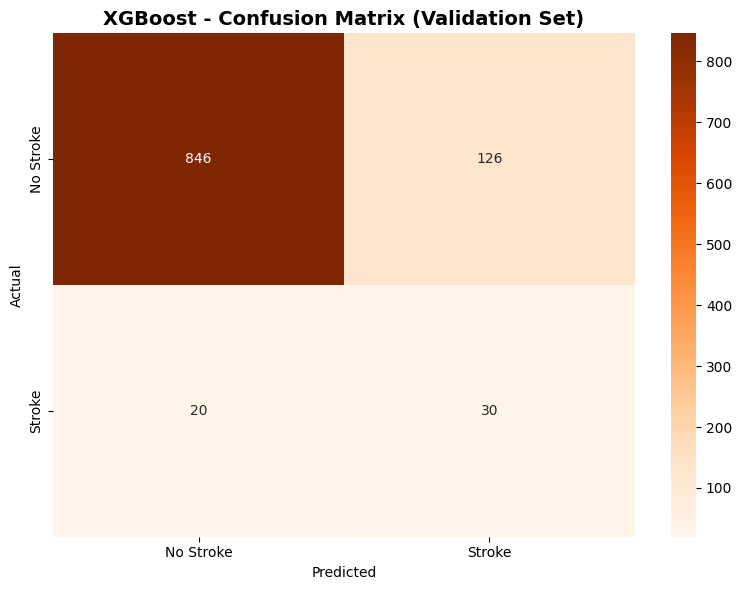


FEATURE IMPORTANCE (XGBoost):
                           Feature  Importance
0                              age    0.194869
10              work_type_children    0.157713
6                 ever_married_Yes    0.115875
1                     hypertension    0.080901
4                              bmi    0.066540
2                    heart_disease    0.059223
3                avg_glucose_level    0.057223
9          work_type_Self-employed    0.045281
12  smoking_status_formerly smoked    0.043000
14           smoking_status_smokes    0.041225


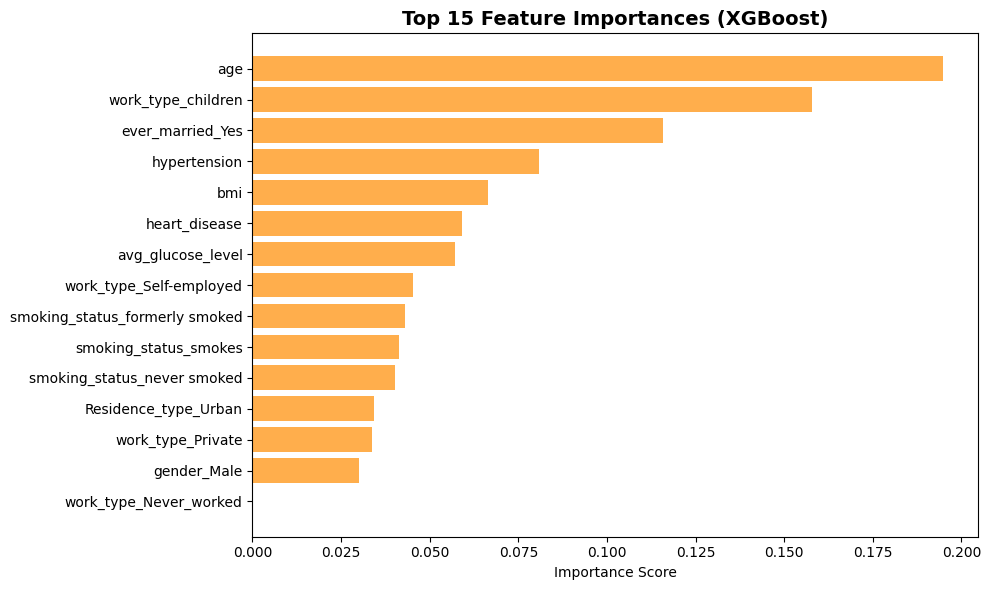


XGBoost model training and evaluation completed!


In [48]:
print("="*70)
print("MODEL 3: XGBOOST")
print("="*70)

# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

print("\nHyperparameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"   {param}: {values}")

# Calculate scale_pos_weight for class imbalance directly from y_train
# This replaces SMOTE, as per user's request for minimal preprocessing.
positive_class_count = y_train.sum()
negative_class_count = len(y_train) - positive_class_count
scale_pos_weight_value = negative_class_count / positive_class_count if positive_class_count > 0 else 1

# Initialize XGBoost
xgb_model = XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value # Account for class imbalance directly
)

# Perform Grid Search (using RandomizedSearchCV for faster computation)
from sklearn.model_selection import RandomizedSearchCV

print("\nPerforming Randomized Search with 10-Fold Cross-Validation...")
print("This may take several minutes...")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# Fit on the raw training data (X_train contains NaNs in bmi, XGBoost can handle them)
xgb_random_search.fit(X_train, y_train)

# Get best model
best_xgb = xgb_random_search.best_estimator_

print("\n" + "="*70)
print("BEST HYPERPARAMETERS:")
print("="*70)
for param, value in xgb_random_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nBest F1-Score (CV): {xgb_random_search.best_score_:.4f}")

# Predictions on validation set
# Use X_val directly as per minimal preprocessing request
y_val_pred_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

# Find optimal threshold for F2-score
optimal_threshold_xgb = find_optimal_threshold_f2(y_val, y_val_pred_proba_xgb)
print(f"\nOptimal Threshold (F2-score) for XGBoost on Validation Set: {optimal_threshold_xgb:.4f}")

# Generate predictions using the optimal threshold
y_val_pred_xgb = (y_val_pred_proba_xgb >= optimal_threshold_xgb).astype(int)

# Calculate metrics
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, y_val_pred_xgb),
    'Precision': precision_score(y_val, y_val_pred_xgb),
    'Recall': recall_score(y_val, y_val_pred_xgb),
    'F1-Score': f1_score(y_val, y_val_pred_xgb),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_xgb),
    'Optimal_Threshold': optimal_threshold_xgb
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in xgb_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('XGBoost - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (XGBoost):")
print("="*70)

feature_importances_xgb = best_xgb.feature_importances_
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_train.columns, # Use original columns
    'Importance': feature_importances_xgb
}).sort_values('Importance', ascending=False)

print(feature_importance_df_xgb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_df_xgb.head(15)
plt.barh(range(len(top_features_xgb)), top_features_xgb['Importance'], color='darkorange', alpha=0.7)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nXGBoost model training and evaluation completed!")

### 4. Ensemble (XGBoost + SVM)

MODEL 4: ENSEMBLE (XGBoost + SVM)

Creating Soft Voting Ensemble...
Base Models: XGBoost + SVM
Voting Strategy: Soft (averaging probabilities)
Note: Base models are already trained and will use their specific preprocessing paths.

Probabilities combined for ensemble!

Optimal Threshold (F2-score) for Ensemble (XGBoost+SVM) on Validation Set: 0.2838

VALIDATION SET PERFORMANCE:
Accuracy: 0.8591
Precision: 0.1948
Recall: 0.6000
F1-Score: 0.2941
ROC-AUC: 0.8372
Optimal_Threshold: 0.2838

Confusion Matrix:
[[848 124]
 [ 20  30]]


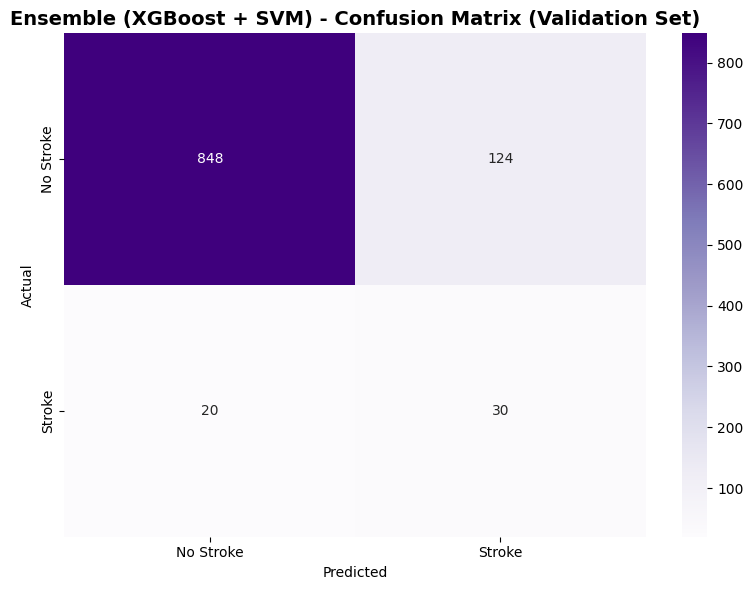


COMPARISON: Individual Models vs Ensemble


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Optimal_Threshold
Model,,,,,,
XGBoost,0.857143,0.192308,0.60,0.291262,0.837078,0.507448
SVM (Pipeline),0.685910,0.093093,0.62,0.161880,0.635885,0.055321
XGBoost + SVM,0.859100,0.194805,0.60,0.294118,0.837243,0.283820



Ensemble (XGBoost + SVM) evaluation completed!


In [49]:
print("="*70)
print("MODEL 4: ENSEMBLE (XGBoost + SVM)")
print("="*70)

print("\nCreating Soft Voting Ensemble...")
print("Base Models: XGBoost + SVM")
print("Voting Strategy: Soft (averaging probabilities)")
print("Note: Base models are already trained and will use their specific preprocessing paths.")

# --- Get probabilities from base models on validation set ---

# XGBoost predictions: uses X_val directly
y_val_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

# SVM predictions: uses X_val (raw data with NaNs for BMI), as best_svm is a pipeline
# that handles imputation and scaling internally.
y_val_proba_svm = best_svm.predict_proba(X_val)[:, 1]

# Combine probabilities (soft voting - simple average)
y_val_pred_proba_ensemble1 = (y_val_proba_xgb + y_val_proba_svm) / 2

print("\nProbabilities combined for ensemble!")

# Find optimal threshold for F2-score
optimal_threshold_ensemble1 = find_optimal_threshold_f2(y_val, y_val_pred_proba_ensemble1)
print(f"\nOptimal Threshold (F2-score) for Ensemble (XGBoost+SVM) on Validation Set: {optimal_threshold_ensemble1:.4f}")

# Generate predictions using the optimal threshold
y_val_pred_ensemble1 = (y_val_pred_proba_ensemble1 >= optimal_threshold_ensemble1).astype(int)

# Calculate metrics
ensemble1_metrics = {
    'Model': 'XGBoost + SVM',
    'Accuracy': accuracy_score(y_val, y_val_pred_ensemble1),
    'Precision': precision_score(y_val, y_val_pred_ensemble1),
    'Recall': recall_score(y_val, y_val_pred_ensemble1),
    'F1-Score': f1_score(y_val, y_val_pred_ensemble1),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_ensemble1),
    'Optimal_Threshold': optimal_threshold_ensemble1
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in ensemble1_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_ensemble1 = confusion_matrix(y_val, y_val_pred_ensemble1)
print("\nConfusion Matrix:")
print(cm_ensemble1)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble1, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Ensemble (XGBoost + SVM) - Confusion Matrix (Validation Set)',
         fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Compare individual models vs ensemble
print("\n" + "="*70)
print("COMPARISON: Individual Models vs Ensemble")
print("="*70)

comparison_df = pd.DataFrame([
    {**xgb_metrics},
    {**svm_metrics},
    {**ensemble1_metrics}
])
comparison_df = comparison_df.set_index('Model')
display(comparison_df)

print("\nEnsemble (XGBoost + SVM) evaluation completed!")

### 5. Ensemble (XGBoost + TabNet)

MODEL 5: ENSEMBLE (XGBoost + TabNet)

Creating Stacked Ensemble with Meta-Learner...
   Base Models: XGBoost + TabNet
   Meta-Learner: Logistic Regression
   Strategy: Stacked Generalization

Step 1: Generating base model predictions...
Meta-features shape: (1022, 2)

Step 2: Generating out-of-fold predictions for meta-learner training...
epoch 0  | loss: 0.48506 |  0:00:00s
epoch 1  | loss: 0.19572 |  0:00:00s
epoch 2  | loss: 0.18547 |  0:00:01s
epoch 3  | loss: 0.17087 |  0:00:02s
epoch 4  | loss: 0.17122 |  0:00:02s
epoch 5  | loss: 0.16236 |  0:00:03s
epoch 6  | loss: 0.16137 |  0:00:04s
epoch 7  | loss: 0.15866 |  0:00:04s
epoch 8  | loss: 0.16006 |  0:00:05s
epoch 9  | loss: 0.15378 |  0:00:05s
epoch 10 | loss: 0.15103 |  0:00:06s
epoch 11 | loss: 0.15194 |  0:00:06s
epoch 12 | loss: 0.1544  |  0:00:06s
epoch 13 | loss: 0.15565 |  0:00:07s
epoch 14 | loss: 0.14739 |  0:00:07s
epoch 15 | loss: 0.14841 |  0:00:08s
epoch 16 | loss: 0.14462 |  0:00:08s
epoch 17 | loss: 0.14685 |  0:

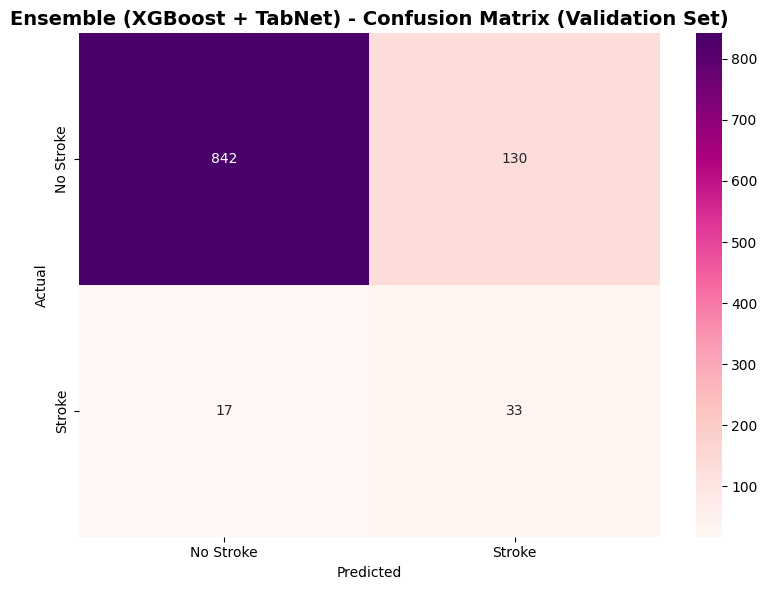


META-LEARNER COEFFICIENTS:
XGBoost weight: 2.8171
TabNet weight:  5.7041
Intercept:      -4.6248

COMPARISON: All Models


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Optimal_Threshold
Model,,,,,,
SVM (Pipeline),0.685910,0.093093,0.62,0.161880,0.635885,0.055321
TabNet,0.863014,0.228916,0.76,0.351852,0.856019,0.095823
XGBoost,0.857143,0.192308,0.60,0.291262,0.837078,0.507448
XGBoost + SVM,0.859100,0.194805,0.60,0.294118,0.837243,0.283820
XGBoost + TabNet,0.856164,0.202454,0.66,0.309859,0.853313,0.061952



Ensemble (XGBoost + TabNet) evaluation completed!


In [50]:
print("="*70)
print("MODEL 5: ENSEMBLE (XGBoost + TabNet)")
print("="*70)

print("\nCreating Stacked Ensemble with Meta-Learner...")
print("   Base Models: XGBoost + TabNet")
print("   Meta-Learner: Logistic Regression")
print("   Strategy: Stacked Generalization")

# Step 1: Get predictions from base models on validation set
print("\nStep 1: Generating base model predictions...")

# XGBoost predictions: uses X_val directly
xgb_val_proba = best_xgb.predict_proba(X_val)[:, 1]

# TabNet predictions: uses X_val after imputation and scaling
tabnet_val_proba = tabnet_model.predict_proba(X_val_imputed_scaled_tabnet)[:, 1]

# Combine predictions as features for meta-learner
meta_features_val = np.column_stack([
    xgb_val_proba,  # XGBoost probability for class 1
    tabnet_val_proba  # TabNet probability for class 1
])

print(f"Meta-features shape: {meta_features_val.shape}")

# Step 2: Train meta-learner on validation predictions
# But we need to generate predictions on training data first using cross-validation
print("\nStep 2: Generating out-of-fold predictions for meta-learner training...")

from sklearn.model_selection import cross_val_predict

# Get out-of-fold predictions on training data for XGBoost (uses X_train directly)
xgb_train_proba = cross_val_predict(
    best_xgb, X_train, y_train,
    cv=5, method='predict_proba', n_jobs=-1
)[:, 1]

# For TabNet, retrain on full training data (imputed and scaled) and use those predictions
tabnet_model_temp = TabNetClassifier(**tabnet_params)
tabnet_model_temp.fit(
    X_train_imputed_scaled_tabnet, y_train_tabnet,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
tabnet_train_proba = tabnet_model_temp.predict_proba(X_train_imputed_scaled_tabnet)[:, 1]

# Create meta-features for training
meta_features_train = np.column_stack([
    xgb_train_proba,
    tabnet_train_proba
])

print(f"Meta-features for training shape: {meta_features_train.shape}")

# Step 3: Train meta-learner (Logistic Regression)
print("\nStep 3: Training meta-learner (Logistic Regression)...")

meta_learner = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
meta_learner.fit(meta_features_train, y_train) # Train with original y_train

print("Meta-learner training completed!")

# Step 4: Make final predictions using meta-learner
print("\nStep 4: Making final ensemble predictions...")

y_val_pred_proba_ensemble2 = meta_learner.predict_proba(meta_features_val)[:, 1]

# Find optimal threshold for F2-score
optimal_threshold_ensemble2 = find_optimal_threshold_f2(y_val, y_val_pred_proba_ensemble2)
print(f"\nOptimal Threshold (F2-score) for Ensemble (XGBoost+TabNet) on Validation Set: {optimal_threshold_ensemble2:.4f}")

# Generate predictions using the optimal threshold
y_val_pred_ensemble2 = (y_val_pred_proba_ensemble2 >= optimal_threshold_ensemble2).astype(int)

# Calculate metrics
ensemble2_metrics = {
    'Model': 'XGBoost + TabNet',
    'Accuracy': accuracy_score(y_val, y_val_pred_ensemble2),
    'Precision': precision_score(y_val, y_val_pred_ensemble2),
    'Recall': recall_score(y_val, y_val_pred_ensemble2),
    'F1-Score': f1_score(y_val, y_val_pred_ensemble2),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_ensemble2),
    'Optimal_Threshold': optimal_threshold_ensemble2
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in ensemble2_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_ensemble2 = confusion_matrix(y_val, y_val_pred_ensemble2)
print("\nConfusion Matrix:")
print(cm_ensemble2)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble2, annot=True, fmt='d', cmap='RdPu', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Ensemble (XGBoost + TabNet) - Confusion Matrix (Validation Set)',
         fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Meta-learner coefficients
print("\n" + "="*70)
print("META-LEARNER COEFFICIENTS:")
print("="*70)
print(f"XGBoost weight: {meta_learner.coef_[0][0]:.4f}")
print(f"TabNet weight:  {meta_learner.coef_[0][1]:.4f}")
print(f"Intercept:      {meta_learner.intercept_[0]:.4f}")

# Compare all models
print("\n" + "="*70)
print("COMPARISON: All Models")
print("="*70)

all_comparison_df = pd.DataFrame([
    {**svm_metrics},
    {**tabnet_metrics},
    {**xgb_metrics},
    {**ensemble1_metrics},
    {**ensemble2_metrics}
])
all_comparison_df = all_comparison_df.set_index('Model')
display(all_comparison_df)

print("\nEnsemble (XGBoost + TabNet) evaluation completed!")

## 7. Final Evaluation on Test Set

In [51]:
model_mapping = {
    'SVM (Pipeline)': {
        'model': best_svm,
        'X_data': X_test  # SVM pipeline handles imputation/scaling internally
    },
    'TabNet': {
        'model': tabnet_model,
        'X_data': X_test_imputed_scaled_tabnet  # TabNet expects NumPy array, preprocessed
    },
    'XGBoost': {
        'model': best_xgb,
        'X_data': X_test  # XGBoost expects raw data with NaNs
    },
    'XGBoost + SVM': {
        'model': None, # No single model object, predictions are combined
        'X_data': None  # Data will be handled by individual base models
    },
    'XGBoost + TabNet': {
        'model': None, # No single model object, predictions are combined via meta-learner
        'X_data': None  # Data will be handled by individual base models and meta-learner
    }
}

print("Model mapping defined for ROC curve plotting.")

Model mapping defined for ROC curve plotting.


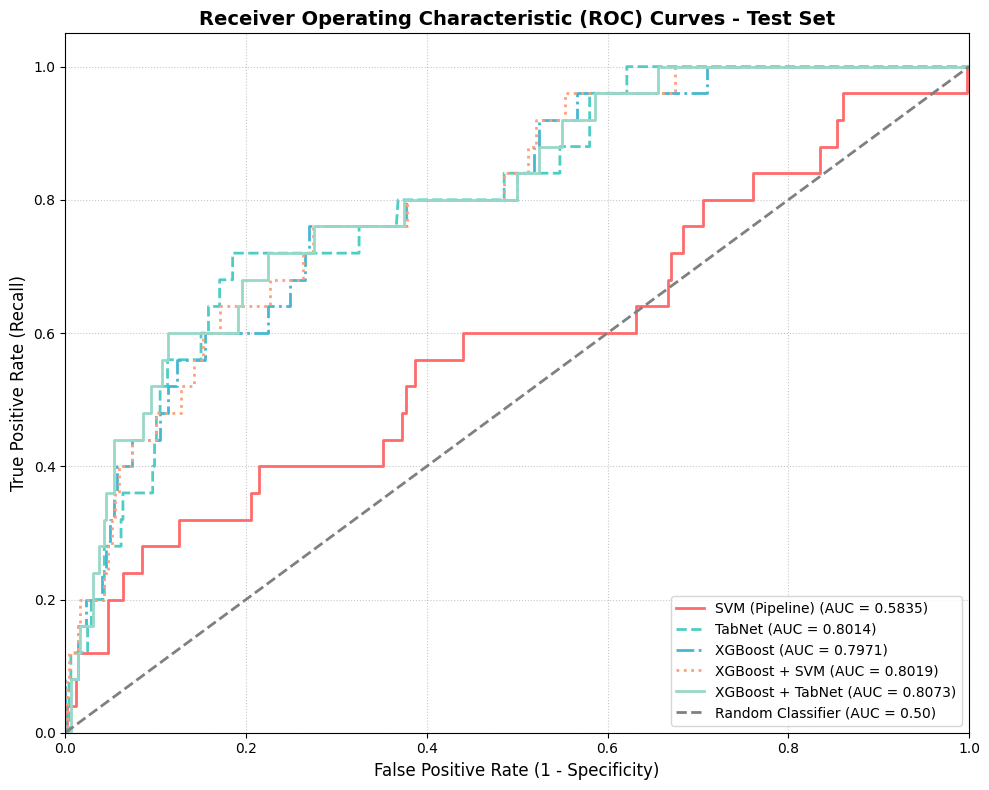

ROC-AUC analysis completed!


In [52]:
# Initialize dictionary to store ROC data for plotting
models_roc_data = {}

# Prepare data for plotting ROC curves for each model
for model_name, model_info in model_mapping.items():
    current_model = model_info['model']
    X_test_data = model_info['X_data']

    y_test_pred_proba = None

    if model_name == 'TabNet':
        y_test_pred_proba = current_model.predict_proba(X_test_data)[:, 1]
    elif model_name == 'XGBoost + SVM':
        xgb_test_proba = best_xgb.predict_proba(X_test)[:, 1]
        svm_test_proba = best_svm.predict_proba(X_test)[:, 1]
        y_test_pred_proba = (xgb_test_proba + svm_test_proba) / 2
    elif model_name == 'XGBoost + TabNet':
        xgb_test_proba = best_xgb.predict_proba(X_test)[:, 1]
        tabnet_test_proba = tabnet_model.predict_proba(X_test_imputed_scaled_tabnet)[:, 1] # Use imputed/scaled for TabNet
        meta_features_test = np.column_stack([
            xgb_test_proba,
            tabnet_test_proba
        ])
        y_test_pred_proba = meta_learner.predict_proba(meta_features_test)[:, 1]
    else: # SVM (Pipeline) and XGBoost
        y_test_pred_proba = current_model.predict_proba(X_test_data)[:, 1]

    # Calculate FPR, TPR, and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    models_roc_data[model_name] = (fpr, tpr, roc_auc)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'] # Custom color palette
linestyles = ['-', '--', '-.', ':', '-']

for i, (model_name, (fpr, tpr, roc_auc)) in enumerate(models_roc_data.items()):
    plt.plot(fpr, tpr, color=colors[i], linestyle=linestyles[i], lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("ROC-AUC analysis completed!")

In [53]:
all_models_metrics = pd.DataFrame([svm_metrics, tabnet_metrics, xgb_metrics, ensemble1_metrics, ensemble2_metrics]).set_index('Model')

# Dictionary to store test metrics for all models
test_results = {}

# Iterate through each model in model_mapping to evaluate on the test set
for model_name, model_info in model_mapping.items():
    current_model = model_info['model']
    X_test_data = model_info['X_data']

    # Get optimal threshold from validation set for this model
    optimal_threshold = all_models_metrics.loc[model_name]['Optimal_Threshold']

    y_test_pred_proba = None

    if model_name == 'TabNet':
        y_test_pred_proba = current_model.predict_proba(X_test_data)[:, 1]
    elif model_name == 'XGBoost + SVM':
        xgb_test_proba = best_xgb.predict_proba(X_test)[:, 1]
        svm_test_proba = best_svm.predict_proba(X_test)[:, 1]
        y_test_pred_proba = (xgb_test_proba + svm_test_proba) / 2
    elif model_name == 'XGBoost + TabNet':
        xgb_test_proba = best_xgb.predict_proba(X_test)[:, 1]
        tabnet_test_proba = tabnet_model.predict_proba(X_test_imputed_scaled_tabnet)[:, 1] # Use imputed/scaled for TabNet
        meta_features_test = np.column_stack([
            xgb_test_proba,
            tabnet_test_proba
        ])
        y_test_pred_proba = meta_learner.predict_proba(meta_features_test)[:, 1]
    else: # SVM (Pipeline) and XGBoost
        y_test_pred_proba = current_model.predict_proba(X_test_data)[:, 1]

    # Generate predictions using the optimal threshold
    y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

    # Calculate metrics on the test set
    test_results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba)
    }

# Convert results to DataFrame
test_results_df = pd.DataFrame(test_results).T # Transpose to have models as index

print("\n" + "="*70)
print("TEST SET EVALUATION RESULTS (for reference):")
print("="*70)
display(test_results_df.round(4))

metrics_to_evaluate = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Create a DataFrame to store ranks for each model across different metrics
model_ranks = pd.DataFrame(index=test_results_df.index)

print("\n" + "="*70)
print("MODEL RANKING BY METRIC (HIGHER IS BETTER):")
print("="*70)

for metric in metrics_to_evaluate:
    # Rank models for the current metric (higher value gets lower rank number)
    # .rank(ascending=False) assigns rank 1 to the highest value
    model_ranks[metric + '_Rank'] = test_results_df[metric].rank(ascending=False)

    best_model_for_metric = test_results_df[metric].idxmax()
    best_value_for_metric = test_results_df[metric].max()
    print(f"\nBest Model for {metric}: {best_model_for_metric} ({metric} = {best_value_for_metric:.4f})")

# Calculate the average rank for each model across all metrics
model_ranks['Average_Rank'] = model_ranks.mean(axis=1)

print("\n" + "="*70)
print("OVERALL MODEL RANKING (Based on Average Rank):")
print("="*70)

# Sort by average rank to find the overall best model (lower average rank is better)
overall_best_models = model_ranks.sort_values(by='Average_Rank')
display(overall_best_models.round(2))

# Identify the single best model based on average rank
best_overall_model_name = overall_best_models.index[0]
best_overall_model_avg_rank = overall_best_models.iloc[0]['Average_Rank']

print(f"\nOverall Best Model (based on average rank): {best_overall_model_name} (Average Rank = {best_overall_model_avg_rank:.2f})")

# --- Add comparison of best model's validation vs. test metrics ---
print("\n" + "="*70)
print(f"VALIDATION vs TEST PERFORMANCE - {best_overall_model_name}")
print("="*70)

# Define common metrics to compare, excluding 'Optimal_Threshold' as it's not directly comparable in performance
common_metrics_for_comparison = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

comparison_best_val_test = pd.DataFrame({
    'Validation': all_models_metrics.loc[best_overall_model_name][common_metrics_for_comparison],
    'Test': test_results_df.loc[best_overall_model_name][common_metrics_for_comparison]
})
display(comparison_best_val_test.round(4))

print("\nPerformance Difference (Test - Validation):")
diff_best_model = comparison_best_val_test['Test'] - comparison_best_val_test['Validation']
for metric, value in diff_best_model.items():
    sign = '+' if value >= 0 else ''
    print(f"   {metric:12s}: {sign}{value:.4f}")

print("\nModel ranking analysis completed!")


TEST SET EVALUATION RESULTS (for reference):


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
SVM (Pipeline),0.6341,0.0598,0.44,0.1053,0.5835
TabNet,0.8513,0.1772,0.56,0.2692,0.8014
XGBoost,0.8669,0.1884,0.52,0.2766,0.7971
XGBoost + SVM,0.8689,0.1818,0.48,0.2637,0.8019
XGBoost + TabNet,0.8552,0.1899,0.60,0.2885,0.8073



MODEL RANKING BY METRIC (HIGHER IS BETTER):

Best Model for Accuracy: XGBoost + SVM (Accuracy = 0.8689)

Best Model for Precision: XGBoost + TabNet (Precision = 0.1899)

Best Model for Recall: XGBoost + TabNet (Recall = 0.6000)

Best Model for F1-Score: XGBoost + TabNet (F1-Score = 0.2885)

Best Model for ROC-AUC: XGBoost + TabNet (ROC-AUC = 0.8073)

OVERALL MODEL RANKING (Based on Average Rank):


,Accuracy_Rank,Precision_Rank,Recall_Rank,F1-Score_Rank,ROC-AUC_Rank,Average_Rank
XGBoost + TabNet,3.0,1.0,1.0,1.0,1.0,1.4
XGBoost,2.0,2.0,3.0,2.0,4.0,2.6
XGBoost + SVM,1.0,3.0,4.0,4.0,2.0,2.8
TabNet,4.0,4.0,2.0,3.0,3.0,3.2
SVM (Pipeline),5.0,5.0,5.0,5.0,5.0,5.0



Overall Best Model (based on average rank): XGBoost + TabNet (Average Rank = 1.40)

VALIDATION vs TEST PERFORMANCE - XGBoost + TabNet


,Validation,Test
Accuracy,0.8562,0.8552
Precision,0.2025,0.1899
Recall,0.6600,0.6000
F1-Score,0.3099,0.2885
ROC-AUC,0.8533,0.8073



Performance Difference (Test - Validation):
   Accuracy    : -0.0010
   Precision   : -0.0126
   Recall      : -0.0600
   F1-Score    : -0.0214
   ROC-AUC     : -0.0460

Model ranking analysis completed!


## 8. Save Best Models and Results

In [54]:
import joblib
import os

# Define a directory to save the models and results
save_dir = 'saved_models_and_results'
os.makedirs(save_dir, exist_ok=True)

print(f"Saving models and results to: {save_dir}/")

# 1. Save individual best models
joblib.dump(best_svm, os.path.join(save_dir, 'best_svm_pipeline.joblib'))
print("Saved best_svm_pipeline.joblib")

joblib.dump(tabnet_model, os.path.join(save_dir, 'tabnet_model.joblib'))
print("Saved tabnet_model.joblib")

joblib.dump(best_xgb, os.path.join(save_dir, 'best_xgboost_model.joblib'))
print("Saved best_xgboost_model.joblib")

joblib.dump(meta_learner, os.path.join(save_dir, 'ensemble_meta_learner.joblib'))
print("Saved ensemble_meta_learner.joblib")

# 2. Save evaluation results DataFrames
all_models_metrics.to_csv(os.path.join(save_dir, 'validation_metrics_summary.csv'))
print("Saved validation_metrics_summary.csv")

test_results_df.to_csv(os.path.join(save_dir, 'test_metrics_summary.csv'))
print("Saved test_metrics_summary.csv")

overall_best_models.to_csv(os.path.join(save_dir, 'overall_model_ranking.csv'))
print("Saved overall_model_ranking.csv")

# Also save the model_mapping for reference if needed (contains pointers to models)
# Note: This might not be directly loadable if models are already loaded, but it's good for structure
joblib.dump(model_mapping, os.path.join(save_dir, 'model_mapping.joblib'))
print("Saved model_mapping.joblib")

print("\nAll specified models and results have been successfully saved!")

Saving models and results to: saved_models_and_results/
Saved best_svm_pipeline.joblib
Saved tabnet_model.joblib
Saved best_xgboost_model.joblib
Saved ensemble_meta_learner.joblib
Saved validation_metrics_summary.csv
Saved test_metrics_summary.csv
Saved overall_model_ranking.csv
Saved model_mapping.joblib

All specified models and results have been successfully saved!
